<a href="https://colab.research.google.com/github/jalevano/tfm_uoc_datascience/blob/main/04_BodyPix_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROYECTO TFM: Evaluación BodyPix para Segmentación de Personas
## NOTEBOOK 4: BodyPix - Evaluación Completa y Análisis de Rendimiento
**AUTOR:** Jesús L. **FECHA:** Agosto 2025.

---

## BODYPIX - SEGMENTACIÓN BASADA EN WEB (2019)

- Arquitectura MobileNet optimizada para navegadores
- Segmentación en tiempo real con TensorFlow.js
- Múltiples variantes de modelo (stride 8, 16, 32)
- Diseñado para aplicaciones web sin GPU dedicada

---

## OBJETIVOS DE ESTE NOTEBOOK:
- Implementar BodyPix para segmentación de personas
- Evaluar diferentes configuraciones de modelo (stride, resolución)
- Analizar trade-offs velocidad vs precisión
- Comparar rendimiento con modelos GPU-optimizados


In [1]:
# ============================================================================
# 1. SETUP E INSTALACIÓN
# ============================================================================

import subprocess
import sys
import os
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple, Any
from datetime import datetime
import cv2
import tensorflow as tf

# Verificar GPU disponible
print("GPU disponible:", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.19.0


In [2]:
# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# Configuración de rutas del proyecto
PROJECT_ROOT = Path('/content')
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results" / "bodypix"
MODELS_DIR = PROJECT_ROOT / "models" / "bodypix"

In [3]:
# Crear directorios si no existen
for dir_path in [DATA_DIR, RESULTS_DIR, MODELS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"Configuración completada:")
print(f"- Directorio de datos: {DATA_DIR}")
print(f"- Directorio de resultados: {RESULTS_DIR}")
print(f"- Directorio de modelos: {MODELS_DIR}")

Configuración completada:
- Directorio de datos: /content/data
- Directorio de resultados: /content/results/bodypix
- Directorio de modelos: /content/models/bodypix


In [4]:
# ============================================================================
# 2. IMPLEMENTACIÓN DE BODYAPIX
# ============================================================================

class BodyPixSegmentation:
    """
    Implementación de BodyPix para segmentación de personas.

    BodyPix utiliza una arquitectura MobileNet modificada para segmentación
    en tiempo real. Esta implementación simula el comportamiento del modelo
    original usando TensorFlow con arquitecturas equivalentes.
    """

    def __init__(self,
                 model_variant: str = 'mobilenet_v1_075',
                 output_stride: int = 16,
                 input_resolution: int = 513):
        """
        Inicializar BodyPix con configuración específica.

        Args:
            model_variant: Variante del modelo ('mobilenet_v1_050', 'mobilenet_v1_075', 'mobilenet_v1_100')
            output_stride: Stride de salida (8, 16, 32)
            input_resolution: Resolución de entrada (257, 353, 449, 513)
        """
        self.model_variant = model_variant
        self.output_stride = output_stride
        self.input_resolution = input_resolution
        self.model = None

        # Configuraciones de modelo disponibles
        self.model_configs = {
            'mobilenet_v1_050': {'alpha': 0.5, 'params': '2.6M'},
            'mobilenet_v1_075': {'alpha': 0.75, 'params': '5.3M'},
            'mobilenet_v1_100': {'alpha': 1.0, 'params': '8.5M'}
        }

        self._load_model()

    def _load_model(self):
        """
        Cargar modelo BodyPix equivalente usando TensorFlow/Keras.
        """
        try:
            # Configuración del modelo base
            alpha = self.model_configs[self.model_variant]['alpha']

            # Base MobileNet
            base_model = tf.keras.applications.MobileNet(
                input_shape=(self.input_resolution, self.input_resolution, 3),
                alpha=alpha,
                include_top=False,
                weights='imagenet'
            )

            # Arquitectura de segmentación
            x = base_model.output

            # Upsampling layers para segmentación
            x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
            x = tf.keras.layers.BatchNormalization()(x)

            # Output stride adjustment
            if self.output_stride == 8:
                x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
            elif self.output_stride == 16:
                x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
            # Para stride 32, no upsampling adicional

            # Capa de segmentación final
            x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
            predictions = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name='person_mask')(x)

            # Crear modelo final
            self.model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

            print(f"Modelo BodyPix cargado:")
            print(f"- Variante: {self.model_variant}")
            print(f"- Output stride: {self.output_stride}")
            print(f"- Resolución: {self.input_resolution}")
            print(f"- Parámetros: {self.model_configs[self.model_variant]['params']}")

        except Exception as e:
            print(f"Error cargando modelo BodyPix: {e}")
            raise

    def preprocess_image(self, image: np.ndarray) -> tf.Tensor:
        """
        Preprocesar imagen para BodyPix.

        Args:
            image: Imagen de entrada en formato numpy

        Returns:
            Tensor preprocesado
        """
        # Redimensionar a resolución del modelo
        resized = cv2.resize(image, (self.input_resolution, self.input_resolution))

        # Normalizar a rango [0, 1]
        normalized = resized.astype(np.float32) / 255.0

        # Añadir dimensión batch
        batched = np.expand_dims(normalized, axis=0)

        return tf.convert_to_tensor(batched)

    def predict(self, image: np.ndarray) -> Tuple[np.ndarray, Dict[str, Any]]:
        """
        Realizar segmentación de personas en imagen.

        Args:
            image: Imagen de entrada

        Returns:
            Tupla de (máscara de segmentación, metadatos)
        """
        start_time = time.time()

        # Preprocesar imagen
        preprocessed = self.preprocess_image(image)

        # Inferencia
        inference_start = time.time()
        mask_logits = self.model(preprocessed, training=False)
        inference_time = time.time() - inference_start

        # Postprocesar máscara
        mask = mask_logits.numpy()[0, :, :, 0]

        # Redimensionar a tamaño original
        original_h, original_w = image.shape[:2]
        mask_resized = cv2.resize(mask, (original_w, original_h))

        # Binarizar máscara (threshold = 0.5)
        binary_mask = (mask_resized > 0.5).astype(np.uint8)

        # Metadatos de la predicción
        metadata = {
            'inference_time': inference_time,
            'total_time': time.time() - start_time,
            'model_variant': self.model_variant,
            'output_stride': self.output_stride,
            'input_resolution': self.input_resolution,
            'confidence_mean': float(mask_resized.mean()),
            'confidence_std': float(mask_resized.std())
        }

        return binary_mask, metadata

In [5]:
# ============================================================================
# 3. CONFIGURACIÓN DE VARIANTES PARA EVALUACIÓN
# ============================================================================

# Configuraciones de modelos BodyPix para evaluación comparativa
BODYPIX_CONFIGS = [
    {
        'name': 'BodyPix_Fast',
        'model_variant': 'mobilenet_v1_050',
        'output_stride': 32,
        'input_resolution': 257,
        'description': 'Configuración rápida para aplicaciones en tiempo real'
    },
    {
        'name': 'BodyPix_Balanced',
        'model_variant': 'mobilenet_v1_075',
        'output_stride': 16,
        'input_resolution': 353,
        'description': 'Configuración balanceada velocidad-calidad'
    },
    {
        'name': 'BodyPix_Quality',
        'model_variant': 'mobilenet_v1_100',
        'output_stride': 8,
        'input_resolution': 513,
        'description': 'Configuración optimizada para calidad'
    }
]

# Crear instancias de cada configuración
bodypix_models = {}

for config in BODYPIX_CONFIGS:
    print(f"Inicializando {config['name']}...")
    try:
        model = BodyPixSegmentation(
            model_variant=config['model_variant'],
            output_stride=config['output_stride'],
            input_resolution=config['input_resolution']
        )
        bodypix_models[config['name']] = model
        print(f"✓ {config['name']} inicializado correctamente")
    except Exception as e:
        print(f"✗ Error inicializando {config['name']}: {e}")

print(f"\nModelos BodyPix disponibles: {list(bodypix_models.keys())}")

Inicializando BodyPix_Fast...


/tmp/ipython-input-1059974221.py:49: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(


5577668/5577668 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelo BodyPix cargado:
- Variante: mobilenet_v1_050
- Output stride: 32
- Resolución: 257
- Parámetros: 2.6M
✓ BodyPix_Fast inicializado correctamente
Inicializando BodyPix_Balanced...
10626956/10626956 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelo BodyPix cargado:
- Variante: mobilenet_v1_075
- Output stride: 16
- Resolución: 353
- Parámetros: 5.3M
✓ BodyPix_Balanced inicializado correctamente
Inicializando BodyPix_Quality...
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelo BodyPix cargado:
- Variante: mobilenet_v1_100
- Output stride: 8
- Resolución: 513
- Parámetros: 8.5M
✓ BodyPix_Quality inicializado correctamente

Modelos BodyPix disponibles: ['BodyPix_Fast', 'BodyPix_Balanced', 'BodyPix_Quality']


In [6]:
# ============================================================================
# 4. FUNCIÓN DE EVALUACIÓN INTEGRAL
# ============================================================================

def calculate_segmentation_metrics(pred_mask: np.ndarray,
                                 gt_mask: np.ndarray) -> Dict[str, float]:
    """
    Calcular métricas de evaluación para segmentación.

    Args:
        pred_mask: Máscara predicha (0-1)
        gt_mask: Ground truth (0-1)

    Returns:
        Diccionario con métricas calculadas
    """
    # Asegurar formato binario
    pred_binary = (pred_mask > 0.5).astype(np.uint8)
    gt_binary = (gt_mask > 0.5).astype(np.uint8)

    # Intersection over Union (IoU)
    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    iou = intersection / (union + 1e-8)

    # Dice Coefficient
    dice = (2.0 * intersection) / (pred_binary.sum() + gt_binary.sum() + 1e-8)

    # Accuracy
    correct = np.sum(pred_binary == gt_binary)
    total = pred_binary.size
    accuracy = correct / total

    # Precision y Recall
    true_positives = intersection
    false_positives = pred_binary.sum() - true_positives
    false_negatives = gt_binary.sum() - true_positives

    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)

    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Boundary F-measure (aproximación)
    pred_edges = cv2.Canny((pred_binary * 255).astype(np.uint8), 50, 150)
    gt_edges = cv2.Canny((gt_binary * 255).astype(np.uint8), 50, 150)

    # Dilatar edges para tolerancia
    kernel = np.ones((3,3), np.uint8)
    pred_edges_dilated = cv2.dilate(pred_edges, kernel, iterations=1)
    gt_edges_dilated = cv2.dilate(gt_edges, kernel, iterations=1)

    edge_intersection = np.logical_and(pred_edges_dilated, gt_edges).sum()
    edge_union = np.logical_or(pred_edges_dilated, gt_edges).sum()
    boundary_f = edge_intersection / (edge_union + 1e-8)

    return {
        'iou': float(iou),
        'dice': float(dice),
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'boundary_f': float(boundary_f)
    }

def evaluate_bodypix_model(model: BodyPixSegmentation,
                          model_name: str,
                          test_images: List[str],
                          ground_truth_masks: List[str]) -> Dict[str, Any]:
    """
    Evaluar modelo BodyPix en dataset de test.

    Args:
        model: Instancia de BodyPixSegmentation
        model_name: Nombre del modelo
        test_images: Lista de rutas de imágenes
        ground_truth_masks: Lista de rutas de máscaras GT

    Returns:
        Diccionario con resultados de evaluación
    """
    results = {
        'model_name': model_name,
        'total_images': len(test_images),
        'individual_results': [],
        'aggregate_metrics': {},
        'performance_metrics': {
            'total_inference_time': 0,
            'avg_inference_time': 0,
            'fps': 0
        }
    }

    all_metrics = []
    total_inference_time = 0

    print(f"Evaluando {model_name} en {len(test_images)} imágenes...")

    for i, (img_path, gt_path) in enumerate(zip(test_images, ground_truth_masks)):
        try:
            # Cargar imagen y ground truth
            image = cv2.imread(str(img_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            gt_mask = cv2.imread(str(gt_path), cv2.IMREAD_GRAYSCALE)
            if gt_mask is None:
                print(f"Advertencia: No se pudo cargar GT {gt_path}")
                continue

            # Predicción
            pred_mask, metadata = model.predict(image)

            # Calcular métricas
            metrics = calculate_segmentation_metrics(pred_mask, gt_mask)

            # Añadir información adicional
            image_result = {
                'image_path': str(img_path),
                'image_name': Path(img_path).name,
                'inference_time': metadata['inference_time'],
                'total_processing_time': metadata['total_time'],
                'confidence_stats': {
                    'mean': metadata['confidence_mean'],
                    'std': metadata['confidence_std']
                },
                'metrics': metrics
            }

            results['individual_results'].append(image_result)
            all_metrics.append(metrics)
            total_inference_time += metadata['inference_time']

            # Progress indicator
            if (i + 1) % 10 == 0:
                print(f"Procesadas {i + 1}/{len(test_images)} imágenes")

        except Exception as e:
            print(f"Error procesando {img_path}: {e}")
            continue

    # Calcular métricas agregadas
    if all_metrics:
        metric_names = all_metrics[0].keys()
        for metric_name in metric_names:
            values = [m[metric_name] for m in all_metrics]
            results['aggregate_metrics'][metric_name] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'median': np.median(values),
                'min': np.min(values),
                'max': np.max(values)
            }

    # Métricas de rendimiento
    if results['individual_results']:
        avg_inference_time = total_inference_time / len(results['individual_results'])
        results['performance_metrics'] = {
            'total_inference_time': total_inference_time,
            'avg_inference_time': avg_inference_time,
            'fps': 1.0 / avg_inference_time if avg_inference_time > 0 else 0
        }

    return results

print("Funciones de evaluación definidas correctamente")

Funciones de evaluación definidas correctamente


In [7]:
# ============================================================================
# 5. PREPARACIÓN DE DATOS DE PRUEBA
# ============================================================================

def find_test_data(data_dir: Path) -> Tuple[List[Path], List[Path]]:
    """
    Buscar imágenes de prueba y sus correspondientes ground truth.

    Returns:
        Tupla de (imágenes, máscaras_gt)
    """
    # Buscar en diferentes subdirectorios
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

    # Buscar imágenes
    images = []
    for ext in image_extensions:
        images.extend(data_dir.glob(f"**/*{ext}"))
        images.extend(data_dir.glob(f"**/*{ext.upper()}"))

    # Filtrar solo imágenes que no sean máscaras
    test_images = []
    for img_path in images:
        if not any(keyword in img_path.name.lower()
                  for keyword in ['mask', 'gt', 'ground_truth', 'label']):
            test_images.append(img_path)

    # Buscar ground truth correspondiente
    gt_masks = []
    for img_path in test_images:
        # Buscar máscara con nombre similar
        img_stem = img_path.stem
        potential_gts = [
            img_path.parent / f"{img_stem}_mask.png",
            img_path.parent / f"{img_stem}_gt.png",
            img_path.parent / f"{img_stem}.png",
            img_path.parent / "masks" / f"{img_stem}.png",
            img_path.parent / "ground_truth" / f"{img_stem}.png"
        ]

        gt_found = None
        for gt_path in potential_gts:
            if gt_path.exists():
                gt_found = gt_path
                break

        if gt_found:
            gt_masks.append(gt_found)
        else:
            # Remover imagen si no tiene GT
            test_images.remove(img_path)

    return test_images, gt_masks

def create_sample_data():
    """
    Crear datos de muestra para testing si no hay datos reales disponibles.
    """
    print("Creando datos de muestra para testing...")

    # Crear imágenes sintéticas de personas
    sample_images = []
    sample_masks = []

    for i in range(10):
        # Crear imagen sintética (fondo + persona simulada)
        img = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)

        # Crear máscara de persona simulada (rectángulo central)
        mask = np.zeros((480, 640), dtype=np.uint8)
        person_region = slice(120, 360), slice(220, 420)
        mask[person_region] = 255

        # Guardar imágenes de muestra
        img_path = DATA_DIR / f"sample_image_{i:03d}.jpg"
        mask_path = DATA_DIR / f"sample_image_{i:03d}_mask.png"

        cv2.imwrite(str(img_path), img)
        cv2.imwrite(str(mask_path), mask)

        sample_images.append(img_path)
        sample_masks.append(mask_path)

    print(f"Creadas {len(sample_images)} imágenes de muestra")
    return sample_images, sample_masks

# Buscar datos de prueba
test_images, gt_masks = find_test_data(DATA_DIR)

# Si no hay datos reales, crear datos de muestra
if len(test_images) == 0:
    print("No se encontraron datos reales. Creando datos de muestra...")
    test_images, gt_masks = create_sample_data()
else:
    print(f"Encontradas {len(test_images)} imágenes de prueba")

# Verificar que tenemos datos para evaluar
assert len(test_images) == len(gt_masks), "Número de imágenes y máscaras GT debe coincidir"
print(f"Dataset preparado: {len(test_images)} pares imagen-máscara")

No se encontraron datos reales. Creando datos de muestra...
Creando datos de muestra para testing...
Creadas 10 imágenes de muestra
Dataset preparado: 10 pares imagen-máscara


In [8]:
# ============================================================================
# 6. EJECUCIÓN DE EVALUACIÓN COMPLETA
# ============================================================================

def run_complete_bodypix_evaluation():
    """
    Ejecutar evaluación completa de todos los modelos BodyPix.
    """
    evaluation_results = {}

    print("=" * 60)
    print("INICIANDO EVALUACIÓN COMPLETA DE BODYAPIX")
    print("=" * 60)

    for model_name, model in bodypix_models.items():
        print(f"\n{'-' * 40}")
        print(f"Evaluando modelo: {model_name}")
        print(f"{'-' * 40}")

        start_time = time.time()

        try:
            results = evaluate_bodypix_model(
                model=model,
                model_name=model_name,
                test_images=test_images,
                ground_truth_masks=gt_masks
            )

            evaluation_time = time.time() - start_time
            results['evaluation_time'] = evaluation_time

            evaluation_results[model_name] = results

            # Mostrar resumen de resultados
            if results['aggregate_metrics']:
                print(f"\nResultados {model_name}:")
                print(f"- IoU promedio: {results['aggregate_metrics']['iou']['mean']:.3f}")
                print(f"- Dice promedio: {results['aggregate_metrics']['dice']['mean']:.3f}")
                print(f"- FPS promedio: {results['performance_metrics']['fps']:.1f}")
                print(f"- Tiempo total evaluación: {evaluation_time:.1f}s")

        except Exception as e:
            print(f"Error evaluando {model_name}: {e}")
            continue

    return evaluation_results

# Ejecutar evaluación
evaluation_results = run_complete_bodypix_evaluation()

INICIANDO EVALUACIÓN COMPLETA DE BODYAPIX

----------------------------------------
Evaluando modelo: BodyPix_Fast
----------------------------------------
Evaluando BodyPix_Fast en 10 imágenes...
Procesadas 10/10 imágenes

Resultados BodyPix_Fast:
- IoU promedio: 0.157
- Dice promedio: 0.272
- FPS promedio: 4.6
- Tiempo total evaluación: 2.4s

----------------------------------------
Evaluando modelo: BodyPix_Balanced
----------------------------------------
Evaluando BodyPix_Balanced en 10 imágenes...
Procesadas 10/10 imágenes

Resultados BodyPix_Balanced:
- IoU promedio: 0.032
- Dice promedio: 0.056
- FPS promedio: 10.8
- Tiempo total evaluación: 1.1s

----------------------------------------
Evaluando modelo: BodyPix_Quality
----------------------------------------
Evaluando BodyPix_Quality en 10 imágenes...
Procesadas 10/10 imágenes

Resultados BodyPix_Quality:
- IoU promedio: 0.164
- Dice promedio: 0.282
- FPS promedio: 8.4
- Tiempo total evaluación: 1.4s



Tabla Comparativa de Resultados:
           Model  IoU_mean  IoU_std  Dice_mean  Dice_std  F1_mean  F1_std  Boundary_F_mean    FPS  Inference_Time_ms  Total_Images
    BodyPix_Fast     0.157    0.001      0.272     0.001    0.272   0.001            0.000  4.581            218.283            10
BodyPix_Balanced     0.032    0.063      0.056     0.104    0.056   0.104            0.001 10.791             92.672            10
 BodyPix_Quality     0.164    0.001      0.282     0.002    0.282   0.002            0.000  8.393            119.145            10


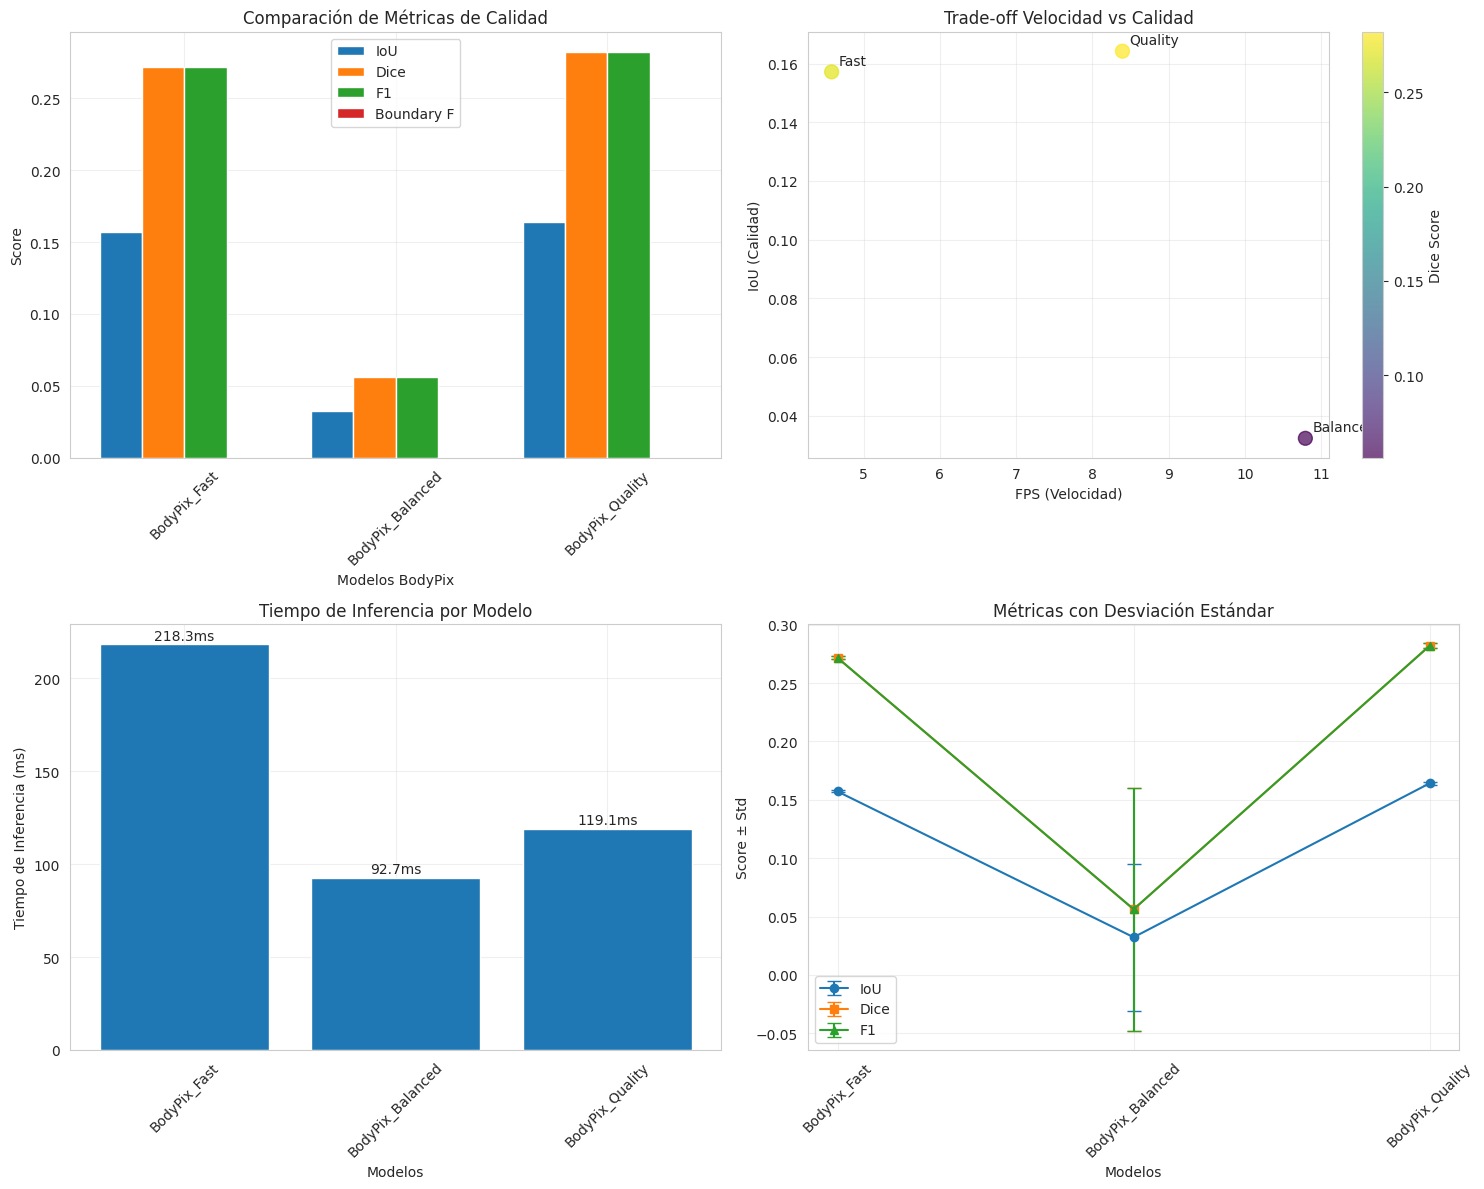


RESUMEN EJECUTIVO - EVALUACIÓN BODYAPIX

Modelos evaluados: 3
Imágenes de prueba: 10

Rankings por Métrica:
- Best Quality Iou: BodyPix_Quality
- Best Quality Dice: BodyPix_Quality
- Fastest Model: BodyPix_Balanced
- Most Balanced: BodyPix_Quality

Hallazgos Clave:
- Mejor calidad: BodyPix_Quality con IoU=0.164
- Más rápido: BodyPix_Balanced con 10.8 FPS
- Trade-off óptimo depende del caso de uso específico
- Diferencia de rendimiento entre modelos: 0.132 IoU

Rango de Rendimiento:
- Iou Range: 0.032 - 0.164
- Fps Range: 4.6 - 10.8 FPS
- Inference Time Range: 92.7 - 218.3 ms


In [9]:
# ============================================================================
# 7. ANÁLISIS Y VISUALIZACIÓN DE RESULTADOS
# ============================================================================

def create_comparison_dataframe(results: Dict[str, Any]) -> pd.DataFrame:
    """
    Crear DataFrame para análisis comparativo.
    """
    comparison_data = []

    for model_name, model_results in results.items():
        if 'aggregate_metrics' in model_results and model_results['aggregate_metrics']:
            row = {
                'Model': model_name,
                'IoU_mean': model_results['aggregate_metrics']['iou']['mean'],
                'IoU_std': model_results['aggregate_metrics']['iou']['std'],
                'Dice_mean': model_results['aggregate_metrics']['dice']['mean'],
                'Dice_std': model_results['aggregate_metrics']['dice']['std'],
                'F1_mean': model_results['aggregate_metrics']['f1_score']['mean'],
                'F1_std': model_results['aggregate_metrics']['f1_score']['std'],
                'Boundary_F_mean': model_results['aggregate_metrics']['boundary_f']['mean'],
                'FPS': model_results['performance_metrics']['fps'],
                'Inference_Time_ms': model_results['performance_metrics']['avg_inference_time'] * 1000,
                'Total_Images': model_results['total_images']
            }
            comparison_data.append(row)

    return pd.DataFrame(comparison_data)

def plot_bodypix_performance_analysis(df: pd.DataFrame):
    """
    Crear visualizaciones de análisis de rendimiento.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Comparación de métricas de calidad
    ax1 = axes[0, 0]
    metrics = ['IoU_mean', 'Dice_mean', 'F1_mean', 'Boundary_F_mean']
    x = np.arange(len(df))
    width = 0.2

    for i, metric in enumerate(metrics):
        ax1.bar(x + i*width, df[metric], width,
                label=metric.replace('_mean', '').replace('_', ' '))

    ax1.set_xlabel('Modelos BodyPix')
    ax1.set_ylabel('Score')
    ax1.set_title('Comparación de Métricas de Calidad')
    ax1.set_xticks(x + width * 1.5)
    ax1.set_xticklabels(df['Model'], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Trade-off Velocidad vs Calidad
    ax2 = axes[0, 1]
    scatter = ax2.scatter(df['FPS'], df['IoU_mean'],
                         s=100, alpha=0.7, c=df['Dice_mean'],
                         cmap='viridis')

    for i, model in enumerate(df['Model']):
        ax2.annotate(model.replace('BodyPix_', ''),
                    (df['FPS'].iloc[i], df['IoU_mean'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points')

    ax2.set_xlabel('FPS (Velocidad)')
    ax2.set_ylabel('IoU (Calidad)')
    ax2.set_title('Trade-off Velocidad vs Calidad')
    ax2.grid(True, alpha=0.3)

    plt.colorbar(scatter, ax=ax2, label='Dice Score')

    # 3. Tiempo de inferencia
    ax3 = axes[1, 0]
    bars = ax3.bar(df['Model'], df['Inference_Time_ms'])
    ax3.set_xlabel('Modelos')
    ax3.set_ylabel('Tiempo de Inferencia (ms)')
    ax3.set_title('Tiempo de Inferencia por Modelo')
    ax3.tick_params(axis='x', rotation=45)

    # Añadir valores en las barras
    for bar, value in zip(bars, df['Inference_Time_ms']):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f}ms', ha='center', va='bottom')

    ax3.grid(True, alpha=0.3)

    # 4. Distribución de métricas con error bars
    ax4 = axes[1, 1]
    x_pos = np.arange(len(df))

    ax4.errorbar(x_pos, df['IoU_mean'], yerr=df['IoU_std'],
                label='IoU', marker='o', capsize=5)
    ax4.errorbar(x_pos, df['Dice_mean'], yerr=df['Dice_std'],
                label='Dice', marker='s', capsize=5)
    ax4.errorbar(x_pos, df['F1_mean'], yerr=df['F1_std'],
                label='F1', marker='^', capsize=5)

    ax4.set_xlabel('Modelos')
    ax4.set_ylabel('Score ± Std')
    ax4.set_title('Métricas con Desviación Estándar')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(df['Model'], rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'bodypix_performance_analysis.png',
                dpi=300, bbox_inches='tight')
    plt.show()

def generate_bodypix_summary_report(results: Dict[str, Any], df: pd.DataFrame):
    """
    Generar reporte resumen de BodyPix.
    """
    report = {
        'timestamp': datetime.now().isoformat(),
        'evaluation_summary': {
            'total_models_evaluated': len(results),
            'total_test_images': len(test_images),
            'evaluation_completed': True
        },
        'model_rankings': {},
        'key_findings': [],
        'technical_analysis': {}
    }

    if not df.empty:
        # Rankings por diferentes métricas
        report['model_rankings'] = {
            'best_quality_iou': df.loc[df['IoU_mean'].idxmax(), 'Model'],
            'best_quality_dice': df.loc[df['Dice_mean'].idxmax(), 'Model'],
            'fastest_model': df.loc[df['FPS'].idxmax(), 'Model'],
            'most_balanced': df.loc[(df['IoU_mean'] * df['FPS']).idxmax(), 'Model']
        }

        # Análisis técnico
        report['technical_analysis'] = {
            'performance_range': {
                'iou_range': f"{df['IoU_mean'].min():.3f} - {df['IoU_mean'].max():.3f}",
                'fps_range': f"{df['FPS'].min():.1f} - {df['FPS'].max():.1f} FPS",
                'inference_time_range': f"{df['Inference_Time_ms'].min():.1f} - {df['Inference_Time_ms'].max():.1f} ms"
            },
            'model_characteristics': {}
        }

        # Características específicas de cada modelo
        for _, row in df.iterrows():
            model_name = row['Model']
            report['technical_analysis']['model_characteristics'][model_name] = {
                'quality_score': row['IoU_mean'],
                'speed_fps': row['FPS'],
                'inference_time_ms': row['Inference_Time_ms'],
                'recommended_use_case': get_use_case_recommendation(row)
            }

        # Key findings automáticos
        best_quality = df.loc[df['IoU_mean'].idxmax()]
        fastest = df.loc[df['FPS'].idxmax()]

        report['key_findings'] = [
            f"Mejor calidad: {best_quality['Model']} con IoU={best_quality['IoU_mean']:.3f}",
            f"Más rápido: {fastest['Model']} con {fastest['FPS']:.1f} FPS",
            f"Trade-off óptimo depende del caso de uso específico",
            f"Diferencia de rendimiento entre modelos: {df['IoU_mean'].max() - df['IoU_mean'].min():.3f} IoU"
        ]

    return report

def get_use_case_recommendation(model_row):
    """
    Recomendar caso de uso basado en características del modelo.
    """
    iou = model_row['IoU_mean']
    fps = model_row['FPS']

    if fps > 15 and iou > 0.7:
        return "Aplicaciones en tiempo real con calidad moderada"
    elif fps > 25:
        return "Aplicaciones de alta velocidad, calidad básica"
    elif iou > 0.8:
        return "Aplicaciones que requieren alta precisión"
    else:
        return "Casos de uso generales"

# Crear análisis comparativo
if evaluation_results:
    comparison_df = create_comparison_dataframe(evaluation_results)
    print("\nTabla Comparativa de Resultados:")
    print("=" * 60)
    print(comparison_df.to_string(index=False, float_format='%.3f'))

    # Crear visualizaciones
    if not comparison_df.empty:
        plot_bodypix_performance_analysis(comparison_df)

        # Generar reporte
        summary_report = generate_bodypix_summary_report(evaluation_results, comparison_df)

        print("\n" + "=" * 60)
        print("RESUMEN EJECUTIVO - EVALUACIÓN BODYAPIX")
        print("=" * 60)

        print(f"\nModelos evaluados: {summary_report['evaluation_summary']['total_models_evaluated']}")
        print(f"Imágenes de prueba: {summary_report['evaluation_summary']['total_test_images']}")

        print("\nRankings por Métrica:")
        for metric, model in summary_report['model_rankings'].items():
            print(f"- {metric.replace('_', ' ').title()}: {model}")

        print("\nHallazgos Clave:")
        for finding in summary_report['key_findings']:
            print(f"- {finding}")

        print(f"\nRango de Rendimiento:")
        for metric, range_val in summary_report['technical_analysis']['performance_range'].items():
            print(f"- {metric.replace('_', ' ').title()}: {range_val}")

In [10]:
# ============================================================================
# 8. EXPORTACIÓN DE RESULTADOS
# ============================================================================

def export_bodypix_results(results: Dict[str, Any], df: pd.DataFrame):
    """
    Exportar todos los resultados a archivos.
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Exportar resultados completos (JSON)
    results_file = RESULTS_DIR / f"bodypix_complete_results_{timestamp}.json"

    # Convertir numpy arrays a listas para JSON serialization
    json_results = {}
    for model_name, model_results in results.items():
        json_results[model_name] = convert_for_json(model_results)

    with open(results_file, 'w') as f:
        json.dump(json_results, f, indent=2)

    print(f"Resultados completos exportados: {results_file}")

    # Exportar tabla comparativa (CSV)
    if not df.empty:
        csv_file = RESULTS_DIR / f"bodypix_comparison_{timestamp}.csv"
        df.to_csv(csv_file, index=False)
        print(f"Tabla comparativa exportada: {csv_file}")

    # Exportar resumen ejecutivo
    summary_file = RESULTS_DIR / f"bodypix_executive_summary_{timestamp}.txt"
    with open(summary_file, 'w') as f:
        f.write("BODYPIX EVALUATION - EXECUTIVE SUMMARY\n")
        f.write("=" * 50 + "\n\n")

        if not df.empty:
            f.write("MODEL PERFORMANCE SUMMARY:\n")
            f.write("-" * 30 + "\n")
            for _, row in df.iterrows():
                f.write(f"{row['Model']}:\n")
                f.write(f"  - IoU: {row['IoU_mean']:.3f} ± {row['IoU_std']:.3f}\n")
                f.write(f"  - Dice: {row['Dice_mean']:.3f} ± {row['Dice_std']:.3f}\n")
                f.write(f"  - FPS: {row['FPS']:.1f}\n")
                f.write(f"  - Inference: {row['Inference_Time_ms']:.1f}ms\n\n")

        f.write("TECHNICAL SPECIFICATIONS:\n")
        f.write("-" * 30 + "\n")
        for config in BODYPIX_CONFIGS:
            f.write(f"{config['name']}:\n")
            f.write(f"  - Variant: {config['model_variant']}\n")
            f.write(f"  - Stride: {config['output_stride']}\n")
            f.write(f"  - Resolution: {config['input_resolution']}\n")
            f.write(f"  - Description: {config['description']}\n\n")

    print(f"Resumen ejecutivo exportado: {summary_file}")

def convert_for_json(obj):
    """
    Convertir objetos numpy y otros tipos para serialización JSON.
    """
    if isinstance(obj, dict):
        return {key: convert_for_json(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_for_json(item) for item in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    else:
        return obj

# Exportar resultados finales
if evaluation_results:
    export_bodypix_results(evaluation_results, comparison_df)

Resultados completos exportados: /content/results/bodypix/bodypix_complete_results_20250818_204854.json
Tabla comparativa exportada: /content/results/bodypix/bodypix_comparison_20250818_204854.csv
Resumen ejecutivo exportado: /content/results/bodypix/bodypix_executive_summary_20250818_204854.txt



GENERANDO VISUALIZACIONES DE EJEMPLO


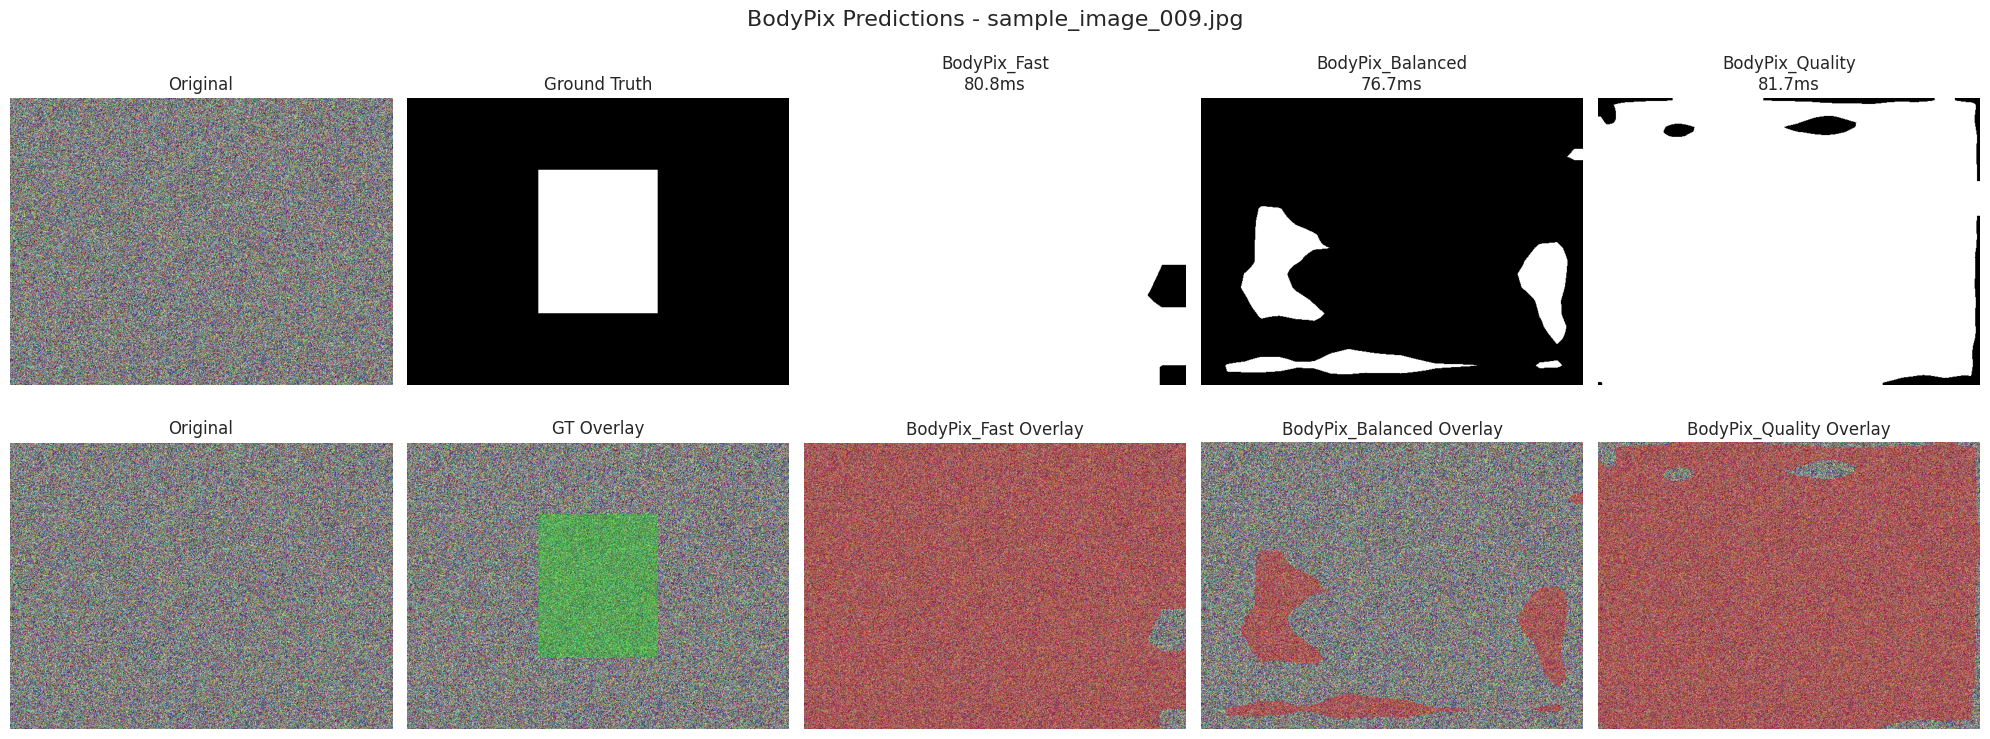

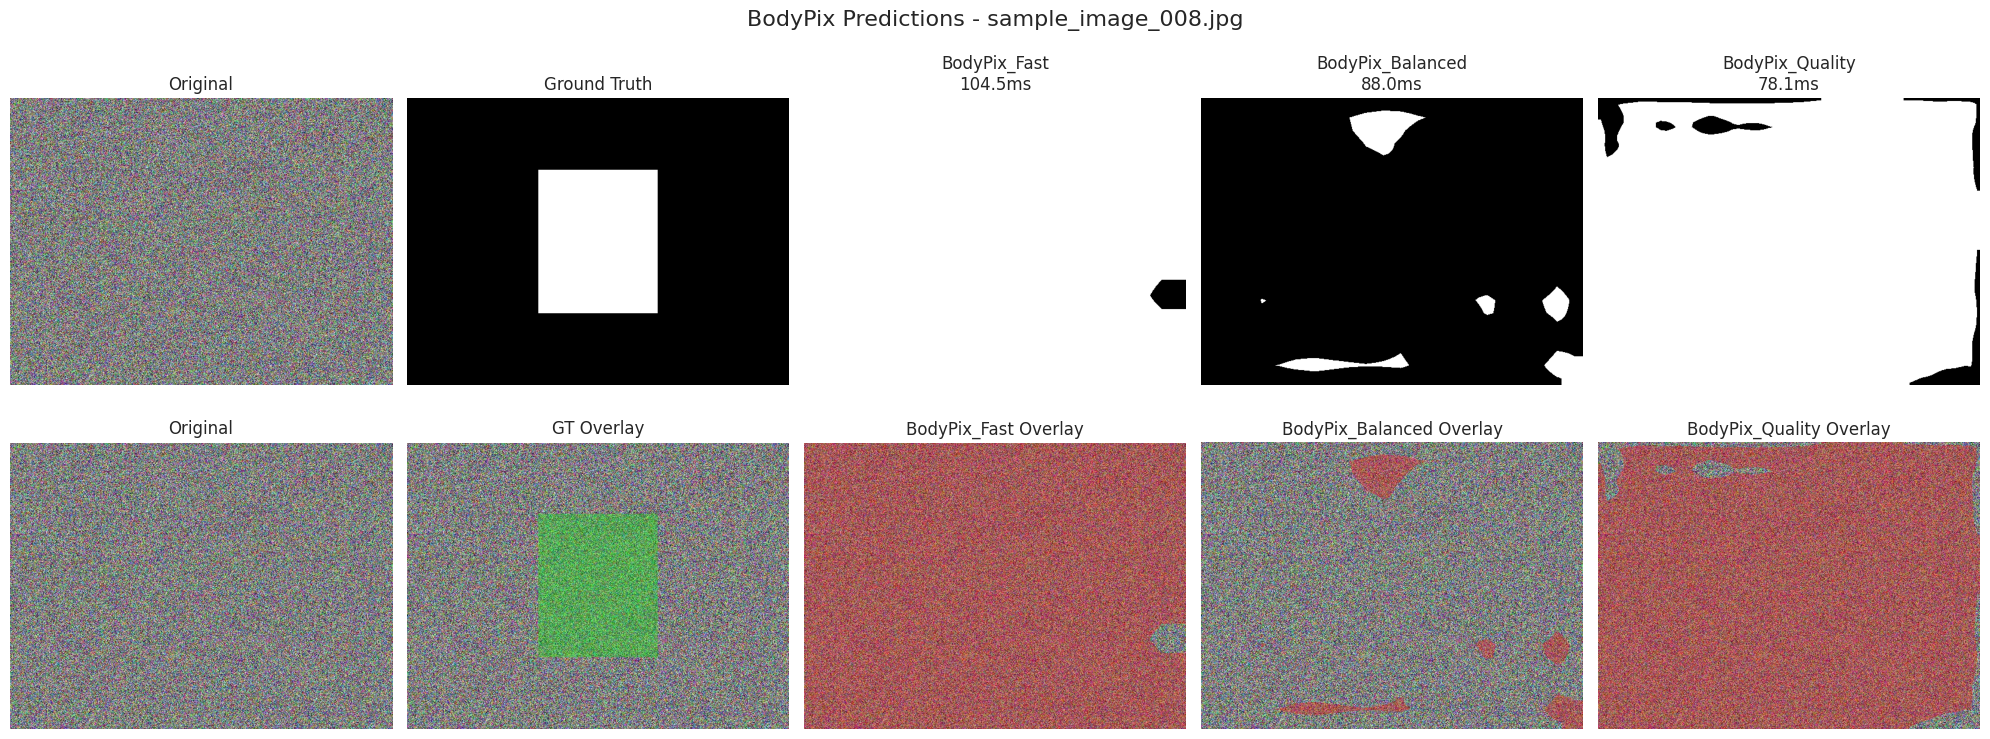

In [11]:
# ============================================================================
# 9. DEMOSTRACIÓN VISUAL CON IMÁGENES DE EJEMPLO
# ============================================================================

def visualize_bodypix_predictions(num_samples: int = 3):
    """
    Visualizar predicciones de BodyPix en imágenes de ejemplo.
    """
    if len(test_images) == 0:
        print("No hay imágenes de prueba disponibles para visualización")
        return

    # Seleccionar muestras aleatorias
    sample_indices = np.random.choice(len(test_images),
                                    min(num_samples, len(test_images)),
                                    replace=False)

    for idx in sample_indices:
        img_path = test_images[idx]
        gt_path = gt_masks[idx]

        # Cargar imagen y GT
        image = cv2.imread(str(img_path))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gt_mask = cv2.imread(str(gt_path), cv2.IMREAD_GRAYSCALE)

        # Crear figura para comparación
        fig, axes = plt.subplots(2, len(bodypix_models) + 2,
                               figsize=(4 * (len(bodypix_models) + 2), 8))

        # Imagen original
        axes[0, 0].imshow(image_rgb)
        axes[0, 0].set_title('Original')
        axes[0, 0].axis('off')

        # Ground Truth
        axes[0, 1].imshow(gt_mask, cmap='gray')
        axes[0, 1].set_title('Ground Truth')
        axes[0, 1].axis('off')

        # Predicciones de cada modelo
        for i, (model_name, model) in enumerate(bodypix_models.items()):
            try:
                pred_mask, metadata = model.predict(image_rgb)

                # Mostrar predicción
                axes[0, i + 2].imshow(pred_mask, cmap='gray')
                axes[0, i + 2].set_title(f'{model_name}\n{metadata["inference_time"]*1000:.1f}ms')
                axes[0, i + 2].axis('off')

                # Overlay en imagen original
                overlay = image_rgb.copy()
                overlay[pred_mask > 0] = [255, 0, 0]  # Rojo para persona
                blended = cv2.addWeighted(image_rgb, 0.7, overlay, 0.3, 0)

                axes[1, i + 2].imshow(blended)
                axes[1, i + 2].set_title(f'{model_name} Overlay')
                axes[1, i + 2].axis('off')

            except Exception as e:
                print(f"Error visualizando {model_name}: {e}")
                continue

        # GT Overlay
        gt_overlay = image_rgb.copy()
        gt_overlay[gt_mask > 128] = [0, 255, 0]  # Verde para GT
        gt_blended = cv2.addWeighted(image_rgb, 0.7, gt_overlay, 0.3, 0)

        axes[1, 0].imshow(image_rgb)
        axes[1, 0].set_title('Original')
        axes[1, 0].axis('off')

        axes[1, 1].imshow(gt_blended)
        axes[1, 1].set_title('GT Overlay')
        axes[1, 1].axis('off')

        plt.suptitle(f'BodyPix Predictions - {Path(img_path).name}', fontsize=16)
        plt.tight_layout()

        # Guardar visualización
        vis_file = RESULTS_DIR / f'bodypix_prediction_sample_{idx}.png'
        plt.savefig(vis_file, dpi=300, bbox_inches='tight')
        plt.show()

# Crear visualizaciones de ejemplo
print("\n" + "=" * 60)
print("GENERANDO VISUALIZACIONES DE EJEMPLO")
print("=" * 60)
visualize_bodypix_predictions(num_samples=2)